In [1]:
!pip install tensorflow

In [2]:
from numpy.random import seed
seed(888)
import tensorflow as tf


In [3]:
random_seed = tf.random.set_seed(404)
random_seed

In [4]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation

from IPython.display import display
from keras.preprocessing.image import array_to_img

import matplotlib.pyplot as plt



In [5]:
LABEL_NAMES = ['Plane','Car','Bird','Cat','Deer', 'Dog','Frog','Horse', 'Ship','Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Explore the Data

In [6]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [7]:
type(cifar10)
type(x_train_all)

numpy.ndarray

In [8]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

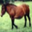

In [9]:
pic = array_to_img(x_train_all[7])
display(pic)

In [10]:
y_train_all.shape

(50000, 1)

In [11]:
y_train_all[7][0]

7

In [12]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

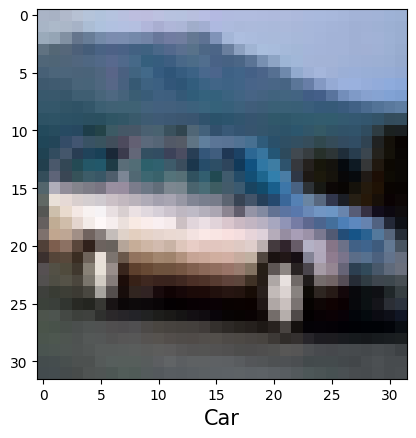

In [13]:
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize=15)
plt.show()

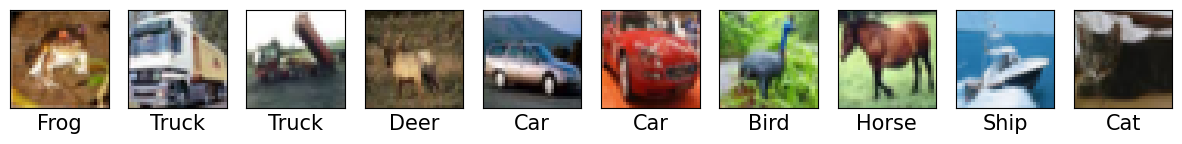

In [14]:
plt.figure(figsize=(15,5))

for i in range(10):
  plt.subplot(1,10,i+1)
  plt.yticks([])
  plt.xticks([])
  plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=15)
  plt.imshow(x_train_all[i])

In [15]:
x_train_all[0].shape

(32, 32, 3)

In [16]:
no_images, x, y, c = x_train_all.shape
print(f"images = {no_images} \t | width = {x} \t | height = {y} \t | channels = {c}")

images = 50000 	 | width = 32 	 | height = 32 	 | channels = 3


In [17]:
x_test.shape

(10000, 32, 32, 3)

# Preprocess Data

In [18]:
type(x_train_all[0][0][0][0])

numpy.uint8

In [19]:
x_train_all, x_test = x_train_all / 255.0 , x_test / 255.0

In [20]:
x_train_all[0][0][0][0]

0.23137254901960785

In [21]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)

In [22]:
x_train_all.shape

(50000, 3072)

In [23]:
x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)
print(f"Shape of x_test is {x_test.shape}")

Shape of x_test is (10000, 3072)


# Creating Validation Dataset

In [24]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

In [25]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
x_train.shape

(40000, 3072)

For Illustration

In [26]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

Neural Network

In [36]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu',name='m1_hidden2'),
    Dense(16, activation='relu',name='m1_hidden3'),
    Dense(10, activation='softmax',name='m1_output')
])

model_1.compile(
optimizer= keras.optimizers.Adam(),
loss= keras.losses.SparseCategoricalCrossentropy(from_logits= True),
metrics= ['accuracy'])

In [34]:
type(model_1)

keras.src.engine.sequential.Sequential

In [37]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402810 (1.54 MB)
Trainable params: 402810 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
